In [1]:
import pandas as pd
import numpy as np
import math

In [2]:
import may_function

In [3]:
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb
import pickle

In [5]:
np.random.seed(42)
random.seed(42)
import warnings
warnings.filterwarnings('ignore')

In [6]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 500)

In [7]:
data = pd.read_pickle('./data_all.zip', compression='zip')

In [8]:
# Еще один алгоритм извлечения данных из данных типа локация

data['adress_2'] = ""
data['latitude_2'] = 0
data['longitude_2'] = 0
for index, row in data.iterrows():
    data['adress_2'][index] = data['adress'][index][0]
    data['latitude_2'][index] = data['adress'][index][1][0]
    data['longitude_2'][index] = data['adress'][index][1][1]
data['adress_2'] = data['adress_2'].str.replace("[\d{5:}]+[\,] ", "", regex = True)
data['geo_2'] = data['adress_2'].str.split(', ').str[-2].factorize()[0] + 1
data['geo_3'] = data['adress_2'].str.split(', ').str[-3].factorize()[0] + 1
data['geo_4'] = data['adress_2'].str.split(', ').str[-4].factorize()[0] + 1
data['geo_5'] = data['adress_2'].str.split(', ').str[-5].factorize()[0] + 1

In [9]:
data['points'] = np.log(data['.geo'].str.count('\.')).astype(np.float16)
data['points'].min(), data['points'].max(),

(2.08, 8.6)

In [10]:
data['adress_2'][0]

'Тоетьяковский территориальный отдел, Борисоглебский городской округ, Воронежская область, Центральный федеральный округ, Россия'

In [11]:
nd_mean = ['2021-04-','2021-05-','2021-06-','2021-07-','2021-08-']
data_columns = []
cols = data.columns
for m in nd_mean:
    for col in cols:
        if col.rfind(m)>0:
            data_columns.append(col)
len(data_columns)

70

In [12]:
nd_mean = ['2021-04','2021-05','2021-06','2021-07','2021-08']
for m in nd_mean:
    temp_columns = []
    for col in data_columns:
        if col.rfind(m)>=0:
            temp_columns.append(col)
    #data[f'cum_mean_{m}']=data[temp_columns].cumsum(axis=1).mean(axis=1)
    data[f'max_{m}']=data[temp_columns].max(axis=1)
    data[f'std_{m}']=data[temp_columns].std(axis=1)

In [13]:
nd_mean = ['max_2021']
data_max = []
cols = data.columns
for m in nd_mean:
    for col in cols:
        if col.rfind(m)>=0:
            data_max.append(col)
data_max

['max_2021-04', 'max_2021-05', 'max_2021-06', 'max_2021-07', 'max_2021-08']

In [14]:
data['mean_all']=data[data_columns].mean(axis=1)
data['std_all']=data[data_columns].std(axis=1)
data["skew_all"] = data[data_columns].skew(axis=1)

In [15]:
for col in data_max:
    data[f'std_{col}']=data.groupby("geo_4")[col].transform(np.std)
    data[f'min_{col}']=data.groupby("geo_4")[col].transform(np.min)
    data[f'median_{col}']=data.groupby("geo_4")[col].transform("median")

In [16]:
s_lat, s_lon = 68.961551, 33.148611
dv_lat, dv_lon = 69.061529, 178.982822

In [17]:
data['latitude_2'] = data['latitude_2'].astype(np.float32)
data['longitude_2'] = data['longitude_2'].astype(np.float32)

data['latitude'] = data['latitude'].astype(np.float32)
data['longitude'] = data['longitude'].astype(np.float32)

In [18]:
data['distance_to_s'] = data[['latitude','longitude']].apply(
    lambda row: may_function.dist_calc(row.latitude, row.longitude, s_lat, s_lon), axis=1)
data['distance_to_s'] = np.log10(data['distance_to_s'])

data['distance_to_dv'] = data[['latitude','longitude']].apply(
    lambda row: may_function.dist_calc(row.latitude, row.longitude, dv_lat, dv_lon), axis=1)
data['distance_to_dv'] = np.log10(data['distance_to_dv'])

In [19]:
data = may_function.downcast_dtypes(data)

In [20]:
drop_all_columns=['.geo', 'area', 'crop', 'id', 'geolist', 'location', 'adress', 'adress_2',
             'geo_2', 'geo_3', 'geo_5', 'longitude', 'latitude', 'points',]

In [21]:
data.fillna(0, inplace=True)

In [22]:
test_df = data[data['crop']==-1].drop(drop_all_columns, axis = 1)
test_df.shape

(2071, 103)

In [23]:
categoricals=['geo_4',]
indexes_of_categories = [test_df.columns.get_loc(col) for col in categoricals]
indexes_of_categories

[82]

In [24]:
X = data[data['crop']>-1].drop(drop_all_columns, axis = 1).to_numpy()
y = data[data['crop']>-1]['crop'].to_numpy() 
X_data = test_df.to_numpy()
X_data.shape

(2071, 103)

In [35]:
rs_params = {
    'max_depth': (9, 12, 10),
    'num_leaves': (15, 10),
    #'min_split_gain': (.0001, .00001),
    #'min_child_samples': (20, 10, 30),
    #'learning_rate': (.095, .097, .0933),
    #'colsample_bytree': (.2, .4, .6, .8, 1),
    #'boosting': ('gbdt', 'rf'),
    'num_iterations': (280, 300)
    
}
lgb_estimator = lgb.LGBMClassifier(objective='multiclass', 
                                   #num_iterations=1000, 
                                   #max_depth=10, 
                                   #num_leaves=10,
                                   num_class=7, categorical_feature=indexes_of_categories,
                                  )
rs_cv = RandomizedSearchCV(estimator=lgb_estimator, param_distributions=rs_params, cv = 5, 
                           n_iter=100, verbose=100, random_state=24)

rs_cv.fit(X, y,verbose=1)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5; 1/12] START max_depth=9, num_iterations=280, num_leaves=15.............
[CV 1/5; 1/12] END max_depth=9, num_iterations=280, num_leaves=15;, score=0.973 total time=  22.8s
[CV 2/5; 1/12] START max_depth=9, num_iterations=280, num_leaves=15.............
[CV 2/5; 1/12] END max_depth=9, num_iterations=280, num_leaves=15;, score=0.975 total time=  19.1s
[CV 3/5; 1/12] START max_depth=9, num_iterations=280, num_leaves=15.............
[CV 3/5; 1/12] END max_depth=9, num_iterations=280, num_leaves=15;, score=0.966 total time=  17.8s
[CV 4/5; 1/12] START max_depth=9, num_iterations=280, num_leaves=15.............
[CV 4/5; 1/12] END max_depth=9, num_iterations=280, num_leaves=15;, score=0.977 total time=  19.6s
[CV 5/5; 1/12] START max_depth=9, num_iterations=280, num_leaves=15.............
[CV 5/5; 1/12] END max_depth=9, num_iterations=280, num_leaves=15;, score=0.982 total time=  18.8s
[CV 1/5; 2/12] START max_depth=9, num_i

[CV 1/5; 10/12] END max_depth=10, num_iterations=280, num_leaves=10;, score=0.976 total time=  13.5s
[CV 2/5; 10/12] START max_depth=10, num_iterations=280, num_leaves=10...........
[CV 2/5; 10/12] END max_depth=10, num_iterations=280, num_leaves=10;, score=0.979 total time=  11.9s
[CV 3/5; 10/12] START max_depth=10, num_iterations=280, num_leaves=10...........
[CV 3/5; 10/12] END max_depth=10, num_iterations=280, num_leaves=10;, score=0.968 total time=  12.3s
[CV 4/5; 10/12] START max_depth=10, num_iterations=280, num_leaves=10...........
[CV 4/5; 10/12] END max_depth=10, num_iterations=280, num_leaves=10;, score=0.982 total time=  14.5s
[CV 5/5; 10/12] START max_depth=10, num_iterations=280, num_leaves=10...........
[CV 5/5; 10/12] END max_depth=10, num_iterations=280, num_leaves=10;, score=0.987 total time=  24.6s
[CV 1/5; 11/12] START max_depth=10, num_iterations=300, num_leaves=15...........
[CV 1/5; 11/12] END max_depth=10, num_iterations=300, num_leaves=15;, score=0.975 total ti

RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(categorical_feature=[82],
                                            num_class=7,
                                            objective='multiclass'),
                   n_iter=100,
                   param_distributions={'max_depth': (9, 12, 10),
                                        'num_iterations': (280, 300),
                                        'num_leaves': (15, 10)},
                   random_state=24, verbose=100)

In [36]:
print(rs_cv.best_score_)
print(rs_cv.best_params_)
print(rs_cv.best_estimator_)
print(rs_cv.best_index_) 

0.9784679089026914
{'num_leaves': 10, 'num_iterations': 280, 'max_depth': 9}
LGBMClassifier(categorical_feature=[82], max_depth=9, num_class=7,
               num_iterations=280, num_leaves=10, objective='multiclass')
1


In [37]:
lgb_model = lgb.LGBMClassifier(categorical_feature=indexes_of_categories, objective='multiclass', num_class=7, 
                               num_iterations=280,
                               max_depth=9,
                               num_leaves=10)
lgb_model.fit(X, y, verbose=1)
preds = lgb_model.predict(X_data)
preds

array([3, 2, 3, ..., 2, 6, 0], dtype=int32)

In [38]:
with open('lgb_model.pickle', 'wb') as f:
    pickle.dump(lgb_model, f)

In [39]:
submission = pd.read_csv('./sample_solution.csv')
submission['crop'] = preds
submission.to_csv('./submission_1.csv', index=False)

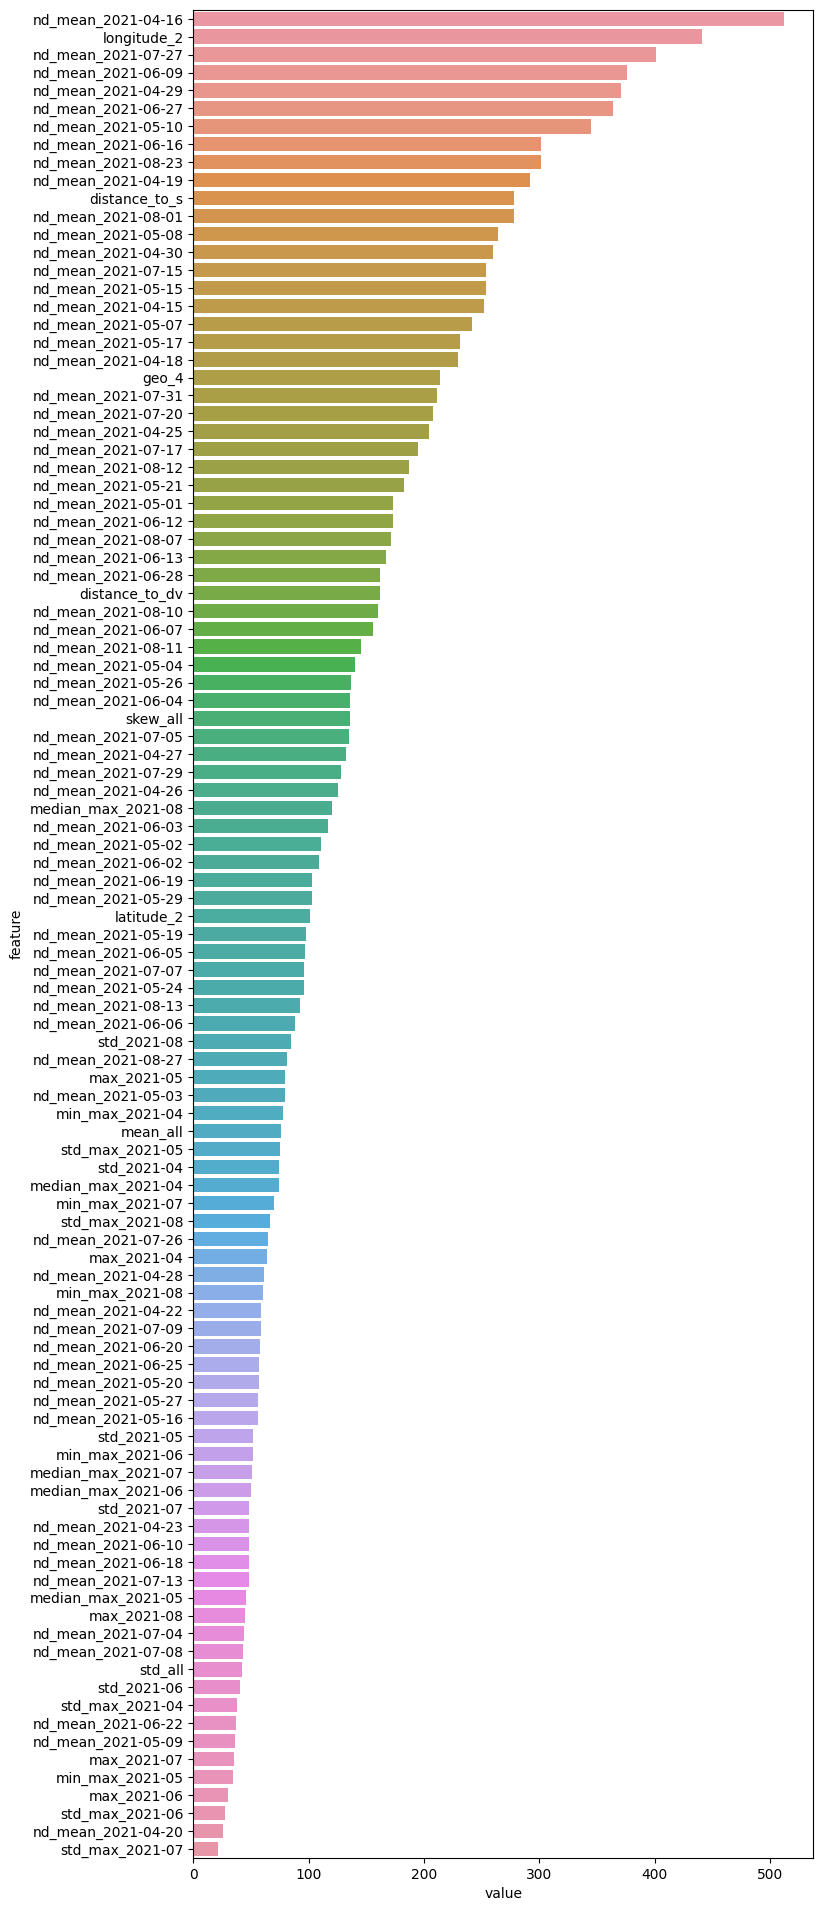

In [40]:
feat_importance = pd.DataFrame()
feat_importance["feature"] = test_df.columns
feat_importance["value"] = lgb_model.feature_importances_
feat_importance.sort_values(by='value', ascending=False, inplace=True)

plt.figure(figsize=(8,24))
ax = sns.barplot(y="feature", x="value", data=feat_importance)